In [16]:

using Images
using PyPlot
using Interpolations
using Optim
using Distributions
using LineSearches


include("studentt.jl");

#
# negative log-likelihood
#
function mrf_nlprior(x::Array{Float64,2}, sigma, alpha)
    
    height,width = size(x);
    disparity=x
    # horizontal compatibility
    h  = disparity[:,1:end-1] - disparity[:,2:end];
    ph = [log_studentt(h, sigma, alpha) zeros(height,1)];

    # vertical compatibility
    v  = disparity[1:end-1,:] - disparity[2:end,:];
    pv = [log_studentt(v, sigma, alpha); zeros(1,width)];

    return -ph - pv;
    
end

#
# gradient of negative log-likelihood
#
function grad_mrf_nlprior(x::Array{Float64,2}, sigma, alpha)
    
    height,width = size(x);
    disparity=x

    # horizontal compatibility
    h  = disparity[:,1:end-1] - disparity[:,2:end];
    dh = grad_log_studentt(h, sigma, alpha);
    ph = hcat(dh, zeros(height,1)) - hcat(zeros(height,1), dh);

    # vertical compatibility
    v  = disparity[1:end-1,:] - disparity[2:end,:];
    dv = grad_log_studentt(v, sigma, alpha);
    pv = vcat(dv, zeros(1,width)) - vcat(zeros(1,width), dv);

    return -ph - pv;
end

#
# inpainting algorithm
#
function inpaint(x, m, sigma, alpha)
    
    x=convert(Array{Float64,2},x)
    
    z=copy(x) # initilise corr image
    counter=0;
    function f(k)  # k param
        return sum(m.*mrf_nlprior(k,sigma,alpha));  ## minimising nll is same as max likelihood
    end

    function g!(storage, k)
        dk = m.*(grad_mrf_nlprior(k,sigma,alpha));  ## this reverses the dirn of grad of log prior 
        counter=counter+1
        if(counter<10)  # keeping the learning rate high initially
        dk=dk*5
        end
        storage[:] = dk[:];
    end
    
    options = Optim.Options(iterations=2000, show_trace=false);#,allow_f_increases=true);
    result = optimize(f, g!, z, GradientDescent(linesearch=StrongWolfe()), options);
    return reshape(Optim.minimizer(result), size(x));
    
end


function psnr(gt,x)
    
    ms=(gt-x).^2
    mss=sum(ms)
    MSE=mss/(size(gt,1)*size(gt,2))  #Mean square error
    vm=255    # maximum pixel intensity
    PSNR=10*log10((vm^2)/MSE)
    
    return PSNR
    
end




psnr (generic function with 1 method)

In [17]:


# loading a sample image
  im = PyPlot.imread("castle.png")
  im=im.*255   ## normalising the image pixels from 0 to 255
  im_org=copy(im) # backing up the image

  #
  # Run with different corruption levels
  #
  sigma = 10  # using the same values as used in problem 1
  alpha = 0.56
  r,c=size(im); #number of rows and columns in the image
  t_pixels=r*c;   # total number of pixels in the image
  
  
 


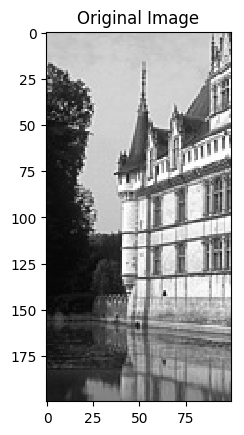

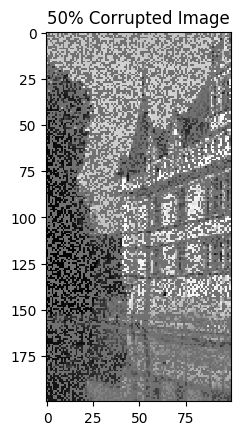

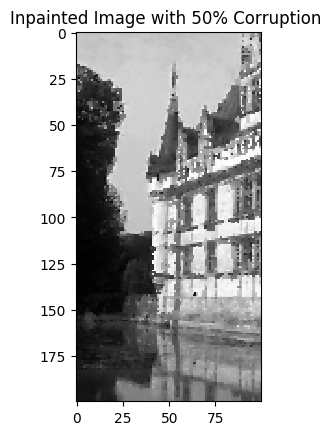

PSNR of Inpainted Image with 50% Corruption 21.9782258298605


In [18]:
############ 50% pixels corruption case ###########
    masking_pixel_Count=0.5*t_pixels # 50% of the pixels need to be masked
    masking_pixel_Count=convert(Int,masking_pixel_Count) # the pixel count has to be converted to integer for arrray operations
    a = randperm(t_pixels)[1:masking_pixel_Count] # randomly selecting 50% of the pixels without repetition
    b=zeros(im);                                  #mask array initialised with zeros 
    for i=1:masking_pixel_Count
        row=ceil(a[i]/100)
        row=convert(Int,row) # converting to int as cant access float as array index
        col=a[i]%100
        if(col==0)  ## last col needs special handling
        col=100
        end
        b[row, col]=1     # for corrupted pixels we mark 1 in mask
     end  

   
    figure()
    PyPlot.imshow(im,"gray")
    title("Original Image")
    for i=1:size(im,1)
        for j=1:size(im,2)
            if(b[i,j]==1)
                im[i,j]=127     # all pixels which are to be corrupted are filled with 127
            end
        end
    end

    
     # corrupt
     mask = b  
     im_corrupt=im
   
     figure()   
     PyPlot.imshow(im_corrupt,"gray") 
     title("50% Corrupted Image")
           
     im_correct = inpaint(im_corrupt, mask, sigma, alpha);
     figure() 
     PyPlot.imshow(im_correct,"gray") 
     title("Inpainted Image with 50% Corruption ") 
      
      
    
     println("PSNR of Inpainted Image with 50% Corruption ", psnr(im_org, im_correct));
    
    
 ############## 50% case end ##################
    
 
    
    

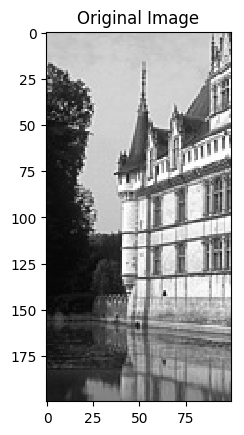

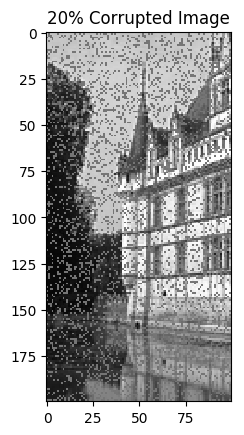

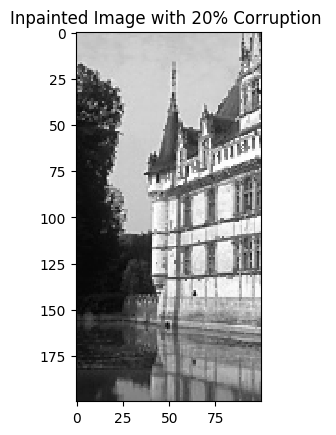

PSNR of Inpainted Image with 20% Corruption : 27.765990082009807


In [19]:
############## 20% pixels corruption case ################
    masking_pixel_Count=0.2*t_pixels
    masking_pixel_Count=convert(Int,masking_pixel_Count)
    im1 = PyPlot.imread("castle.png")
    im1=im1.*255   ## normalising the image pixels from 0 to 255
    a1 = randperm(t_pixels)[1:masking_pixel_Count]
    b1=zeros(im1);
    for i=1:masking_pixel_Count
        row=ceil(a1[i]/100)
        row=convert(Int,row) # converting to int as cant access float as array index
        #display(row)
        col=a1[i]%100
        if(col==0)  ## last col needs special handling
            col=100
        end
        b1[row, col]=1
    end  
   
    
    figure()
    PyPlot.imshow(im1,"gray")
    title("Original Image")
    for i=1:size(im1,1)
        for j=1:size(im1,2)
            if(b1[i,j]==1)
                im1[i,j]=127
            end
        end
    end

    
     # corrupt
     mask1 = b1  ## 1 is corrupted 
     im_corrupt1=im1
   
     figure()   
     PyPlot.imshow(im_corrupt1,"gray")
     title("20% Corrupted Image")
           
      im_correct1 = inpaint(im_corrupt1, mask1, sigma, alpha);
      figure() 
      PyPlot.imshow(im_correct1,"gray")  
      title("Inpainted Image with 20% Corruption ")
    
      println("PSNR of Inpainted Image with 20% Corruption : ", psnr(im_org, im_correct1));
    
 ################20% case end####################   
 
    

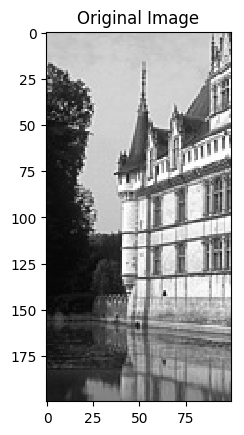

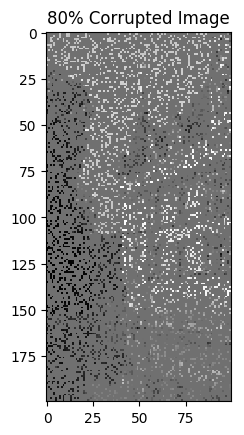

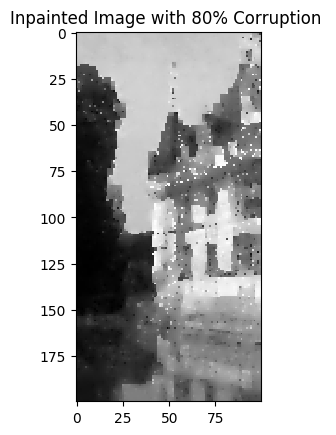

PSNR of Inpainted Image with 80% Corruption : 18.700265139302246


In [20]:
############## 80% pixels corruption case ################
    masking_pixel_Count=0.8*t_pixels
    masking_pixel_Count=convert(Int,masking_pixel_Count)
    im1 = PyPlot.imread("castle.png")
    im1=im1.*255   ## normalising the image pixels from 0 to 255
    a1 = randperm(t_pixels)[1:masking_pixel_Count]
    b1=zeros(im1);
    for i=1:masking_pixel_Count
        row=ceil(a1[i]/100)
        row=convert(Int,row) # converting to int as cant access float as array index
        #display(row)
        col=a1[i]%100
        if(col==0)  ## last col needs special handling
            col=100
        end
        b1[row, col]=1
    end  
   
    
    figure()
    PyPlot.imshow(im1,"gray")
    title("Original Image")
    for i=1:size(im1,1)
        for j=1:size(im1,2)
            if(b1[i,j]==1)
                im1[i,j]=127
            end
        end
    end

    
     # corrupt
     mask1 = b1  ## 1 is corrupted 
     im_corrupt1=im1
   
     figure()   
     PyPlot.imshow(im_corrupt1,"gray")
     title("80% Corrupted Image")
           
      im_correct1 = inpaint(im_corrupt1, mask1, sigma, alpha);
      figure() 
      PyPlot.imshow(im_correct1,"gray")  
      title("Inpainted Image with 80% Corruption ")
    
      println("PSNR of Inpainted Image with 80% Corruption : ", psnr(im_org, im_correct1));
    
 ################80% case end####################    